# Réseau de neurones pour le calcul de flux pour l'advection en 2D

Importer les bibliothèques utiles 

In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sqlite3
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import datetime, os
from sklearn import metrics
from sklearn import preprocessing
from sklearn.utils import shuffle
from time import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

from sklearn.preprocessing import StandardScaler


from joblib import dump
from sklearn.model_selection import GridSearchCV

Importer la base de donnée et visualiser les dernieres lignes

In [7]:
con=sqlite3.connect('Table.db')
raw_data=pd.read_sql_query("SELECT * FROM A",con)
data = raw_data.copy()
print(data.tail())
print(type(data))

                   P1            P2            P3            P4            P5  \
3991999  1.044813e-24  1.365423e-24  1.783170e-24  1.044813e-24  1.580897e-24   
3992000  1.073063e-24  9.264329e-25  7.989262e-25  1.401159e-24  1.210625e-24   
3992001  1.828304e-24  1.401159e-24  1.073063e-24  1.580897e-24  1.210625e-24   
3992002  1.365423e-24  1.580897e-24  1.828304e-24  1.044813e-24  1.210625e-24   
3992003  7.989262e-25  1.044813e-24  1.365423e-24  7.989262e-25  1.210625e-24   

                   P6            P7            P8            P9            F1  \
3991999  2.384010e-24  1.401159e-24  1.401159e-24  2.384010e-24  1.127537e-27   
3992000  1.044813e-24  1.828304e-24  1.580897e-24  1.365423e-24  5.199348e-28   
3992001  7.989262e-25  1.365423e-24  1.044813e-24  7.989262e-25  1.000165e-27   
3992002  1.073063e-24  7.989262e-25  7.989262e-25  1.073063e-24  6.791624e-28   
3992003  1.828304e-24  1.073063e-24  1.073063e-24  1.828304e-24  8.637148e-28   

         ...            F3

# Introduction de la stabilité

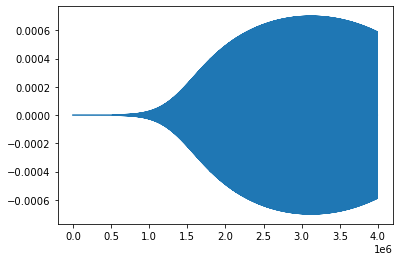

In [9]:
#Attention, on devra peut-etre faire varier dt et dx (=dy)
dx=0.01 #?
dy=0.01 #?
dt=0.01 #?

#Calcul fonction objectif
w = 1 #A recalculer
obj = (data['F1']-data['F4'])/(dx*w)+(data['F3']-data['F2'])/(dy*w)
absi = data.index
plt.plot(absi,obj)

# Scaler les données

but : moyenne = 0 et Ecart type = 1 >> recours a la fonction : preprocessing.StandardScaler()



In [10]:
x=data.values
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
data_scaled = pd.DataFrame(x_scaled)
data_scaled.columns = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','F1','F2','F3','F4','A1','B1','A2','B2','A3','B3','A4','B4']
data_scaled


,P1,P2,P3,P4,P5,P6,P7,P8,P9,F1,...,F3,F4,A1,B1,A2,B2,A3,B3,A4,B4
0,-0.540951,-0.540950,-0.540949,-0.541029,-0.540950,-0.540812,-0.540951,-0.540892,-0.540949,-0.468064,...,-0.468085,-0.468064,0.001660,1.414077,0.000841,1.413754,0.001984,1.414672,0.001166,1.414348
1,-0.540951,-0.540951,-0.540951,-0.541029,-0.540950,-0.540812,-0.540949,-0.540891,-0.540949,-0.468085,...,-0.468064,-0.468085,1.413754,-0.000841,1.414348,-0.001166,1.414077,-0.001660,1.414672,-0.001984
2,-0.540949,-0.540950,-0.540951,-0.541028,-0.540950,-0.540813,-0.540949,-0.540891,-0.540951,-0.468064,...,-0.468085,-0.468064,-0.001166,-1.414348,-0.001984,-1.414672,-0.000841,-1.413754,-0.001660,-1.414077
3,-0.540949,-0.540949,-0.540949,-0.541028,-0.540950,-0.540813,-0.540951,-0.540892,-0.540951,-0.468085,...,-0.468064,-0.468085,-1.414672,0.001984,-1.414077,0.001660,-1.414348,0.001166,-1.413754,0.000841
4,-0.540951,-0.540950,-0.540949,-0.541029,-0.540950,-0.540812,-0.540951,-0.540892,-0.540949,-0.468064,...,-0.468085,-0.468064,0.001660,1.414077,0.002254,1.413753,0.003397,1.414669,0.001166,1.414348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991999,-0.540963,-0.540963,-0.540963,-0.541042,-0.540963,-0.540826,-0.540963,-0.540905,-0.540963,-0.468085,...,-0.468085,-0.468085,-0.767532,1.187973,-0.765750,1.188414,-0.767208,1.188567,-0.767800,1.187476
3992000,-0.540963,-0.540963,-0.540963,-0.541042,-0.540963,-0.540826,-0.540963,-0.540905,-0.540963,-0.468085,...,-0.468085,-0.468085,1.188414,0.765750,1.188243,0.766613,1.188738,0.766345,1.188567,0.767208
3992001,-0.540963,-0.540963,-0.540963,-0.541042,-0.540963,-0.540826,-0.540963,-0.540905,-0.540963,-0.468085,...,-0.468085,-0.468085,0.766613,-1.188243,0.767208,-1.188567,0.765750,-1.188414,0.766345,-1.188738
3992002,-0.540963,-0.540963,-0.540963,-0.541042,-0.540963,-0.540826,-0.540963,-0.540905,-0.540963,-0.468085,...,-0.468085,-0.468085,-1.188567,-0.767208,-1.188738,-0.766345,-1.188243,-0.766613,-1.188414,-0.765750


Sauvegarde du scaler pour l'utilisation ultérieure du réseau

In [15]:
dump(scaler,'scaler.bin',compress=True)

['scaler.bin']

# Extraire une 'petite' base de donnée de table.db, taille de l'ordre de 10 000

In [4]:
data_scaled_extraite=data_scaled.sample(frac=0.0025,random_state=0) #extraire 
data_scaled_extraite=shuffle(data_scaled_extraite) #shuffle

Data_copy=data_scaled_extraite.copy()

## Diviser la base de donnée 0.7 > entrainement ET 0.3 > test

In [5]:
print('The shape of the initial data before spliting it'+str(data_scaled_extraite.shape))


data_training=data_scaled_extraite.sample(frac=0.7,random_state=0) 
data_test=data_scaled_extraite.drop(data_training.index)

print('The shape of the initial data for training'+str(data_training.shape))
print('The shape of the initial data for testing'+str(data_test.shape))


data_training_labels = pd.DataFrame(columns =['F1','F2','F3','F4'])
data_test_labels = pd.DataFrame(columns =['F1','F2','F3','F4'])

data_training_labels['F1']=data_training['F1']
data_training_labels['F2']=data_training['F2']
data_training_labels['F3']=data_training['F3']
data_training_labels['F4']=data_training['F4']


data_test_labels['F1']=data_test['F1']
data_test_labels['F2']=data_test['F2']
data_test_labels['F3']=data_test['F3']
data_test_labels['F4']=data_test['F4']

data_training.pop('F1')
data_training.pop('F2')
data_training.pop('F3')
data_training.pop('F4')

data_test.pop('F1')
data_test.pop('F2')
data_test.pop('F3')
data_test.pop('F4')

data_training_features=data_training
data_test_features=data_test

print('The shape of the features dataframe for training'+str(data_training_features.shape))
print('The shape of the features dataframe for testing'+str(data_test_features.shape))
print('The shape of the labels dataframe for training'+str(data_training_labels.shape))
print('The shape of the labels dataframe for testing'+str(data_test_labels.shape))











The shape of the initial data before spliting it(9980, 21)
The shape of the initial data for training(6986, 21)
The shape of the initial data for testing(2994, 21)
The shape of the features dataframe for training(6986, 17)
The shape of the features dataframe for testing(2994, 17)
The shape of the labels dataframe for training(6986, 4)
The shape of the labels dataframe for testing(2994, 4)


## Créer le modèle de réseau de neurones

Définir shape = nombre de 'features' d'entrée

In [6]:
shape = len(data.columns)-4

In [7]:
def build_model(optimizer='adam',activation='relu',dropout=0.2): #les valeurs des parametres sont arbitraires, on optimise apres
    model = keras.Sequential()
    model.add(layers.Dense(17,use_bias=True,input_shape=[shape],activation=activation))
    
    model.add(layers.Dense(20,use_bias=True,input_shape=[shape],activation=activation))
    
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(layers.Dense(50,use_bias=True,input_shape=[shape],activation=activation))
    
    model.add(keras.layers.Dropout(rate=dropout))
    model.add(layers.Dense(4,use_bias=True,activation=activation))
    
 
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_mse',min_delta=1e-17, patience=10)
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1,profile_batch=0)



    return model

Nombre de degré de liberté du réseau : 6 051 , du meme ordre de la taille de la base de données => Overfitting/Underfitting évité

Optimiser le réseau, on choisit l'algorithm Adam et 20 000 epoches ( on peut changer d'algorithm d'optimisation apres ( gradient descent par exemple ), ca dependra de la performance ) 
On a pas encore Etudié le batch_size, on met une valeur arbitraire de 128

La méthode callbacks.TensorBoard() a été ajouté pour conserver la performence du Réseau de neurones a chaque itération (epochs) et visualiser les courbes a la fin

# GridSeachCV

In [9]:
from keras.wrappers.scikit_learn import KerasRegressor

model1=KerasRegressor(build_fn=build_model)

#create the grid to optimize the hyperparameters on : 
batch = [30,60,90,120]
EPOCHS = [600]
optimiz = ['SGD','Adam','Adadelta']
dropout = [0.2]
ACTIVATION = ['relu','sigmoid','elu']
param_grid=dict(epochs=EPOCHS,batch_size=batch,optimizer=optimiz,activation=ACTIVATION,dropout=dropout)

#optimise the model on the grid :

grid=GridSearchCV(estimator=model1,param_grid=param_grid,n_jobs=-1,cv=5) 
grid_result=grid.fit(data_training_features,data_training_labels)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/600
59/59 [==============================] - 0s 1ms/step - loss: 0.4394 - mse: 0.4394
Epoch 2/600
59/59 [==============================] - 0s 1ms/step - loss: 0.2741 - mse: 0.2741
Epoch 3/600
59/59 [==============================] - 0s 1ms/step - loss: 0.2110 - mse: 0.2110
Epoch 4/600
59/59 [==============================] - 0s 1ms/step - loss: 0.1686 - mse: 0.1686
Epoch 5/600
59/59 [==============================] - 0s 1ms/step - loss: 0.1426 - mse: 0.1426
Epoch 6/600
59/59 [==============================] - 0s 1ms/step - loss: 0.1145 - mse: 0.1145
Epoch 7/600
59/59 [==============================] - 0s 1ms/step - loss: 0.1022 - mse: 0.1022
Epoch 8/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0948 - mse: 0.0948
Epoch 9/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0899 - mse: 0.0899
Epoch 10/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0824 - mse: 0.0824
Epoch 11/600
59/59 [==============================] - 0s 1m

59/59 [==============================] - 0s 1ms/step - loss: 0.0265 - mse: 0.0265
Epoch 88/600
59/59 [==============================] - 0s 883us/step - loss: 0.0271 - mse: 0.0271
Epoch 89/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0276 - mse: 0.0276
Epoch 90/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0265 - mse: 0.0265
Epoch 91/600
59/59 [==============================] - 0s 905us/step - loss: 0.0269 - mse: 0.0269
Epoch 92/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0264 - mse: 0.0264
Epoch 93/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0258 - mse: 0.0258
Epoch 94/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0249 - mse: 0.0249
Epoch 95/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0267 - mse: 0.0267
Epoch 96/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0265 - mse: 0.0265
Epoch 97/600
59/59 [==============================] - 0s 1m

59/59 [==============================] - 0s 1ms/step - loss: 0.0191 - mse: 0.0191
Epoch 258/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0201 - mse: 0.0201
Epoch 259/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0197 - mse: 0.0197
Epoch 260/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0182 - mse: 0.0182
Epoch 261/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0193 - mse: 0.0193
Epoch 262/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0193 - mse: 0.0193
Epoch 263/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0197 - mse: 0.0197
Epoch 264/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0189 - mse: 0.0189
Epoch 265/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0200 - mse: 0.0200
Epoch 266/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0213 - mse: 0.0213
Epoch 267/600
59/59 [==============================] -

59/59 [==============================] - 0s 1ms/step - loss: 0.0180 - mse: 0.0180
Epoch 426/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0187 - mse: 0.0187
Epoch 427/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0178 - mse: 0.0178
Epoch 428/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0166 - mse: 0.0166
Epoch 429/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0186 - mse: 0.0186
Epoch 430/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0181 - mse: 0.0181
Epoch 431/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0177 - mse: 0.0177
Epoch 432/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0187 - mse: 0.0187
Epoch 433/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0178 - mse: 0.0178
Epoch 434/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0186 - mse: 0.0186
Epoch 435/600
59/59 [==============================] -

59/59 [==============================] - 0s 1ms/step - loss: 0.0175 - mse: 0.0175
Epoch 594/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0174 - mse: 0.0174
Epoch 595/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0164 - mse: 0.0164
Epoch 596/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0171 - mse: 0.0171
Epoch 597/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0167 - mse: 0.0167
Epoch 598/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0177 - mse: 0.0177
Epoch 599/600
59/59 [==============================] - 0s 1ms/step - loss: 0.0164 - mse: 0.0164
Epoch 600/600
59/59 [==============================] - 0s 905us/step - loss: 0.0169 - mse: 0.0169
Best: -0.002673 using {'activation': 'elu', 'batch_size': 120, 'dropout': 0.2, 'epochs': 600, 'optimizer': 'Adam'}
-0.155923 (0.005467) with: {'activation': 'relu', 'batch_size': 30, 'dropout': 0.2, 'epochs': 600, 'optimizer': 'SGD'}
-0.155188 

In [10]:
# On a les meilleurs parametres, on construit notre réseau : 

# Structure 1

In [8]:
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(17,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(20,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(30,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(20,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(4,use_bias=True,activation='elu'))

    return model

model = build_model()
model.summary()

def train_model():
  
    
  optimizer = tf.optimizers.Adam() #Algorithm d'optimisation

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mse'])

  early_stop = keras.callbacks.EarlyStopping(monitor='val_mse',min_delta=1e-17, patience=10)
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1,profile_batch=0)


  model.fit(data_training_features, 
            data_training_labels, 
            epochs=600,
            batch_size=120,
            validation_split = 0.5, 
            verbose=0, 
            callbacks=[early_stop,tensorboard_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 17)                306       
_________________________________________________________________
dropout (Dropout)            (None, 17)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                360       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                630       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                6

# Save the model in .h5 format 

In [9]:
train_model()
model.save("Advection_2D-structure-1.h5")

# Résultats

In [10]:
Y_pred=model.predict(data_test_features) #output du réseau, qu'on veut comparer a Y_test
Y_test=data_test_labels

Y_preddd=pd.DataFrame(Y_pred,columns=['F1','F2','F3','F4'])

Y_preddd




,F1,F2,F3,F4
0,-0.475145,-0.514146,-0.513973,-0.475565
1,-0.217338,-0.382316,-0.381655,-0.217246
2,0.717987,2.334497,2.332182,0.718303
3,0.196014,0.149551,0.151190,0.195822
4,-0.489311,-0.502489,-0.502636,-0.489765
...,...,...,...,...
2989,-0.475523,-0.520449,-0.520167,-0.475473
2990,1.136695,-0.027312,-0.025713,1.136599
2991,3.603413,0.708704,0.708595,3.602252
2992,-0.488700,-0.508166,-0.508191,-0.489129


In [11]:
def pearsonr(x, y):
  # Assume len(x) == len(y)
  n = len(x)
  sum_x = float(sum(x))
  sum_y = float(sum(y))
  sum_x_sq = sum(xi*xi for xi in x)
  sum_y_sq = sum(yi*yi for yi in y)
  psum = sum(xi*yi for xi, yi in zip(x, y))
  num = psum - (sum_x * sum_y/n)
  den = pow((sum_x_sq - pow(sum_x, 2) / n) * (sum_y_sq - pow(sum_y, 2) / n), 0.5)
  if den == 0: return 0
  return num / den

In [12]:
def visualize1(model, test_features, test_labels): #we feed it the test data
    Y_pred=Y_preddd #output du réseau, qu'on veut comparer a Y_test
    Y_test=data_test_labels
    
    plt.scatter(Y_test['F1'],Y_pred['F1'], color = 'red',marker=".")
    plt.scatter(Y_test['F1'],Y_test['F1'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    
    plt.title('Neural Network prediction de F1')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(Y_test['F1'], Y_pred['F1'])
    
    Correl=pearsonr(Y_test['F1'], Y_pred['F1'])
    
    print('Model Performance')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show()
    
    


In [13]:
def visualize2(model, test_features, test_labels): #we feed it the test data
    Y_pred=Y_preddd #output du réseau, qu'on veut comparer a Y_test
    Y_test=data_test_labels
    
    plt.scatter(Y_test['F2'],Y_pred['F2'], color = 'red',marker=".")
    plt.scatter(Y_test['F2'],Y_test['F2'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    
    plt.title('Neural Network prediction de F2')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(Y_test['F2'], Y_pred['F2'])
    
    Correl=pearsonr(Y_test['F2'], Y_pred['F2'])
    
    print('Model Performance')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show()

In [14]:
def visualize3(model, test_features, test_labels): #we feed it the test data
    Y_pred=Y_preddd #output du réseau, qu'on veut comparer a Y_test
    Y_test=data_test_labels
    
    plt.scatter(Y_test['F3'],Y_pred['F3'], color = 'red',marker=".")
    plt.scatter(Y_test['F3'],Y_test['F3'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    
    plt.title('Neural Network prediction de F3')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(Y_test['F3'], Y_pred['F3'])
    
    Correl=pearsonr(Y_test['F3'], Y_pred['F3'])
    
    print('Model Performance')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show()

In [15]:
def visualize4(model, test_features, test_labels): #we feed it the test data
    Y_pred=Y_preddd #output du réseau, qu'on veut comparer a Y_test
    Y_test=data_test_labels
    
    plt.scatter(Y_test['F4'],Y_pred['F4'], color = 'red',marker=".")
    plt.scatter(Y_test['F4'],Y_test['F4'], color = 'black',marker=".") #just for the y=x black line, the result (red points) should be close to the line
    
    
    plt.title('Neural Network prediction de F4')
    plt.xlabel('exact')
    plt.ylabel('prediction')
    
    R2=metrics.r2_score(Y_test['F4'], Y_pred['F4'])
    
    Correl=pearsonr(Y_test['F4'], Y_pred['F4'])
    
    print('Model Performance')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))
    
    plt.show()

Model Performance
Correlation: 0.9781.
R2: 0.9549.


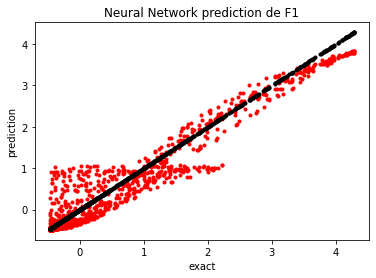

In [16]:
visualize1(model,data_test_features,data_test_labels)

Model Performance
Correlation: 0.9854.
R2: 0.9631.


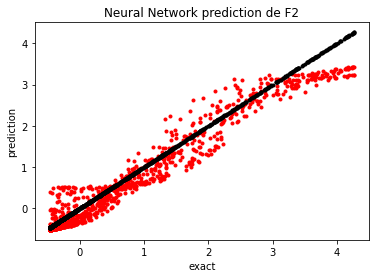

In [17]:
visualize2(model,data_test_features,data_test_labels)

Model Performance
Correlation: 0.9854.
R2: 0.9632.


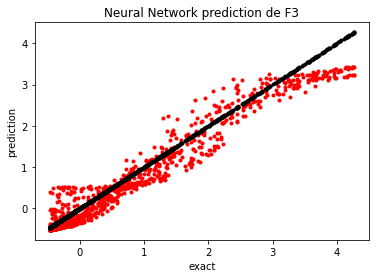

In [18]:
visualize3(model,data_test_features,data_test_labels)

Model Performance
Correlation: 0.9781.
R2: 0.9548.


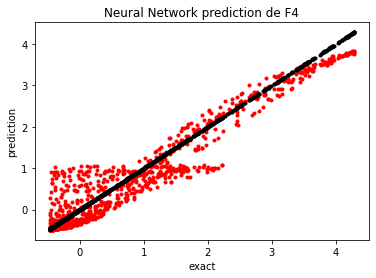

In [19]:
visualize4(model,data_test_features,data_test_labels)

# Structure 2

In [36]:
def build_model2():
    model = keras.Sequential()
    model.add(layers.Dense(17,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(30,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(35,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(30,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(4,use_bias=True,activation='elu'))

    return model

model2 = build_model2()
model2.summary()

def train_model2():
  
    
  optimizer = tf.optimizers.Adam() #Algorithm d'optimisation

  model2.compile(loss='mse',
                optimizer='adam',
                metrics=['mse'])

  early_stop = keras.callbacks.EarlyStopping(monitor='val_mse',min_delta=1e-17, patience=10)
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1,profile_batch=0)


  model2.fit(data_training_features, 
            data_training_labels, 
            epochs=600,
            batch_size=120,
            validation_split = 0.5, 
            verbose=0, 
            callbacks=[early_stop,tensorboard_callback])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 17)                306       
_________________________________________________________________
dropout_35 (Dropout)         (None, 17)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 30)                540       
_________________________________________________________________
dropout_36 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 35)                1085      
_________________________________________________________________
dropout_37 (Dropout)         (None, 35)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 30)               

In [37]:
train_model2()
model2.save("Advection_2D-structure-2.h5")

In [38]:
Y_pred=model2.predict(data_test_features) #output du réseau, qu'on veut comparer a Y_test
Y_test=data_test_labels

Y_preddd=pd.DataFrame(Y_pred,columns=['F1','F2','F3','F4'])

Y_preddd

,F1,F2,F3,F4
0,-0.535254,-0.530918,-0.528075,-0.539414
1,-0.270536,-0.414454,-0.402702,-0.286443
2,0.764774,2.410023,2.458159,0.721312
3,0.301507,-0.061538,-0.062139,0.293097
4,-0.539258,-0.516273,-0.516148,-0.541660
...,...,...,...,...
2989,-0.572358,-0.514278,-0.506910,-0.578339
2990,1.329495,-0.015621,0.004986,1.313407
2991,3.596670,0.814964,0.807604,3.580428
2992,-0.533914,-0.516096,-0.516009,-0.537125


Model Performance
Correlation: 0.9764.
R2: 0.9490.


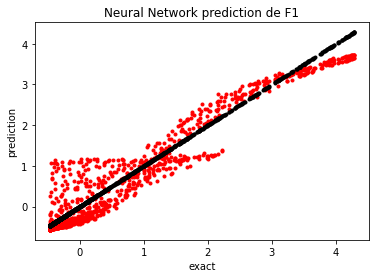

Model Performance
Correlation: 0.9801.
R2: 0.9519.


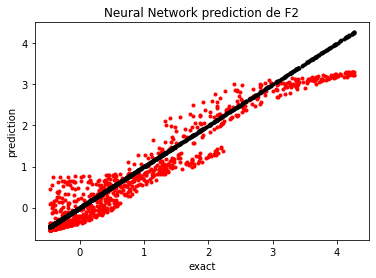

Model Performance
Correlation: 0.9798.
R2: 0.9534.


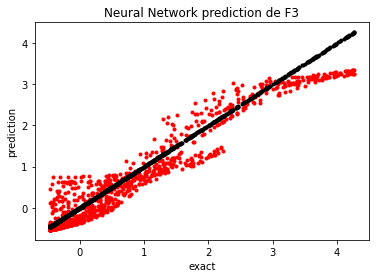

Model Performance
Correlation: 0.9771.
R2: 0.9489.


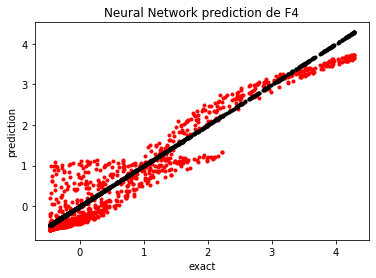

In [39]:
visualize1(model2,data_test_features,data_test_labels)
visualize2(model2,data_test_features,data_test_labels)
visualize3(model2,data_test_features,data_test_labels)
visualize4(model2,data_test_features,data_test_labels)


# Structure 3

In [40]:
def build_model3():
    model = keras.Sequential()
    model.add(layers.Dense(17,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(40,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(40,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(40,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(4,use_bias=True,activation='elu'))

    return model

model3 = build_model3()
model3.summary()

def train_model3():
  
    
  optimizer = tf.optimizers.Adam() #Algorithm d'optimisation

  model3.compile(loss='mse',
                optimizer='adam',
                metrics=['mse'])

  early_stop = keras.callbacks.EarlyStopping(monitor='val_mse',min_delta=1e-17, patience=10)
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1,profile_batch=0)


  model3.fit(data_training_features, 
            data_training_labels, 
            epochs=600,
            batch_size=120,
            validation_split = 0.5, 
            verbose=0, 
            callbacks=[early_stop,tensorboard_callback])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 17)                306       
_________________________________________________________________
dropout_39 (Dropout)         (None, 17)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 40)                720       
_________________________________________________________________
dropout_40 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 40)                1640      
_________________________________________________________________
dropout_41 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 40)              

In [41]:
train_model3()
model3.save("Advection_2D-structure-3.h5")

In [42]:
Y_pred=model2.predict(data_test_features) #output du réseau, qu'on veut comparer a Y_test
Y_test=data_test_labels

Y_preddd=pd.DataFrame(Y_pred,columns=['F1','F2','F3','F4'])

Y_preddd

,F1,F2,F3,F4
0,-0.535254,-0.530918,-0.528075,-0.539414
1,-0.270536,-0.414454,-0.402702,-0.286443
2,0.764774,2.410023,2.458159,0.721312
3,0.301507,-0.061538,-0.062139,0.293097
4,-0.539258,-0.516273,-0.516148,-0.541660
...,...,...,...,...
2989,-0.572358,-0.514278,-0.506910,-0.578339
2990,1.329495,-0.015621,0.004986,1.313407
2991,3.596670,0.814964,0.807604,3.580428
2992,-0.533914,-0.516096,-0.516009,-0.537125


Model Performance
Correlation: 0.9764.
R2: 0.9490.


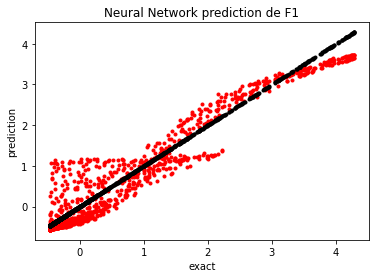

Model Performance
Correlation: 0.9801.
R2: 0.9519.


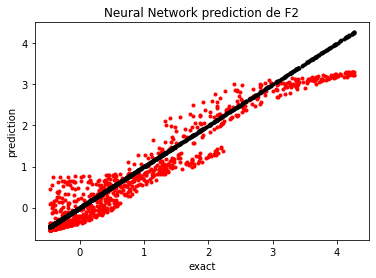

Model Performance
Correlation: 0.9798.
R2: 0.9534.


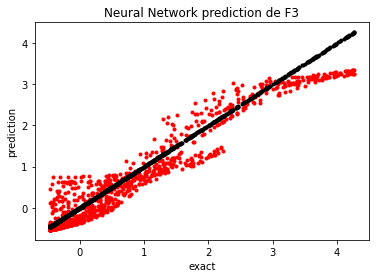

Model Performance
Correlation: 0.9771.
R2: 0.9489.


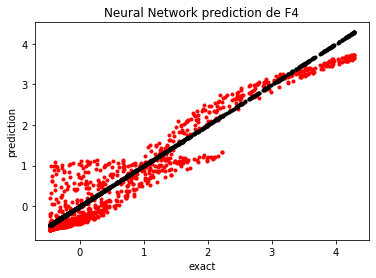

In [43]:
visualize1(model2,data_test_features,data_test_labels)
visualize2(model2,data_test_features,data_test_labels)
visualize3(model2,data_test_features,data_test_labels)
visualize4(model2,data_test_features,data_test_labels)

# Structure 4

In [44]:
def build_model4():
    model = keras.Sequential()
    model.add(layers.Dense(17,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(50,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(50,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(4,use_bias=True,activation='elu'))

    return model

model4 = build_model4()
model4.summary()

def train_model4():
  
    
  optimizer = tf.optimizers.Adam() #Algorithm d'optimisation

  model4.compile(loss='mse',
                optimizer='adam',
                metrics=['mse'])

  early_stop = keras.callbacks.EarlyStopping(monitor='val_mse',min_delta=1e-17, patience=10)
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1,profile_batch=0)


  model4.fit(data_training_features, 
            data_training_labels, 
            epochs=600,
            batch_size=120,
            validation_split = 0.5, 
            verbose=0, 
            callbacks=[early_stop,tensorboard_callback])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 17)                306       
_________________________________________________________________
dropout_43 (Dropout)         (None, 17)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 50)                900       
_________________________________________________________________
dropout_44 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_45 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 4)               

In [45]:
train_model4()
model4.save("Advection_2D-structure-4.h5")

In [46]:
Y_pred=model2.predict(data_test_features) #output du réseau, qu'on veut comparer a Y_test
Y_test=data_test_labels

Y_preddd=pd.DataFrame(Y_pred,columns=['F1','F2','F3','F4'])

Y_preddd

,F1,F2,F3,F4
0,-0.535254,-0.530918,-0.528075,-0.539414
1,-0.270536,-0.414454,-0.402702,-0.286443
2,0.764774,2.410023,2.458159,0.721312
3,0.301507,-0.061538,-0.062139,0.293097
4,-0.539258,-0.516273,-0.516148,-0.541660
...,...,...,...,...
2989,-0.572358,-0.514278,-0.506910,-0.578339
2990,1.329495,-0.015621,0.004986,1.313407
2991,3.596670,0.814964,0.807604,3.580428
2992,-0.533914,-0.516096,-0.516009,-0.537125


Model Performance
Correlation: 0.9764.
R2: 0.9490.


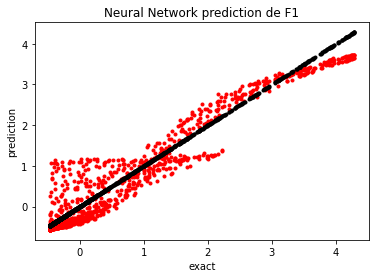

Model Performance
Correlation: 0.9801.
R2: 0.9519.


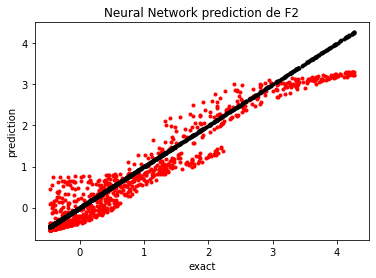

Model Performance
Correlation: 0.9798.
R2: 0.9534.


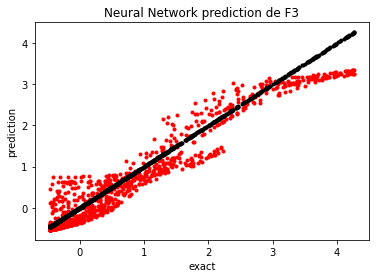

Model Performance
Correlation: 0.9771.
R2: 0.9489.


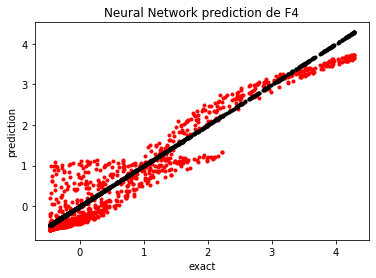

In [47]:
visualize1(model2,data_test_features,data_test_labels)
visualize2(model2,data_test_features,data_test_labels)
visualize3(model2,data_test_features,data_test_labels)
visualize4(model2,data_test_features,data_test_labels)

# Structure 5 (additionnelle)

In [51]:
def build_model5():
    model = keras.Sequential()
    model.add(layers.Dense(17,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(50,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(50,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(50,use_bias=True,input_shape=[shape],activation='elu'))
    model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(4,use_bias=True,activation='elu'))

    return model

model5 = build_model5()
model5.summary()

def train_model5():
  
    
  optimizer = tf.optimizers.Adam() #Algorithm d'optimisation

  model5.compile(loss='mse',
                optimizer='adam',
                metrics=['mse'])

  early_stop = keras.callbacks.EarlyStopping(monitor='val_mse',min_delta=1e-17, patience=10)
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1,profile_batch=0)


  model5.fit(data_training_features, 
            data_training_labels, 
            epochs=600,
            batch_size=120,
            validation_split = 0.5, 
            verbose=0, 
            callbacks=[early_stop,tensorboard_callback])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 17)                306       
_________________________________________________________________
dropout_54 (Dropout)         (None, 17)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 50)                900       
_________________________________________________________________
dropout_55 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_56 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 50)              

In [52]:
train_model5()
model5.save("Advection_2D-structure-5.h5")

In [53]:
Y_pred=model2.predict(data_test_features) #output du réseau, qu'on veut comparer a Y_test
Y_test=data_test_labels

Y_preddd=pd.DataFrame(Y_pred,columns=['F1','F2','F3','F4'])

Y_preddd

,F1,F2,F3,F4
0,-0.535254,-0.530918,-0.528075,-0.539414
1,-0.270536,-0.414454,-0.402702,-0.286443
2,0.764774,2.410023,2.458159,0.721312
3,0.301507,-0.061538,-0.062139,0.293097
4,-0.539258,-0.516273,-0.516148,-0.541660
...,...,...,...,...
2989,-0.572358,-0.514278,-0.506910,-0.578339
2990,1.329495,-0.015621,0.004986,1.313407
2991,3.596670,0.814964,0.807604,3.580428
2992,-0.533914,-0.516096,-0.516009,-0.537125


Model Performance
Correlation: 0.9764.
R2: 0.9490.


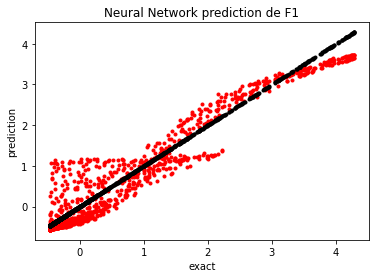

Model Performance
Correlation: 0.9801.
R2: 0.9519.


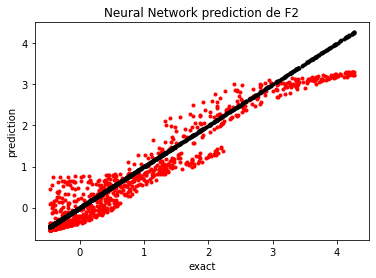

Model Performance
Correlation: 0.9798.
R2: 0.9534.


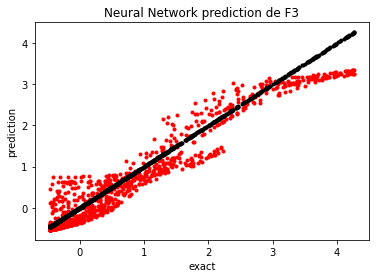

Model Performance
Correlation: 0.9771.
R2: 0.9489.


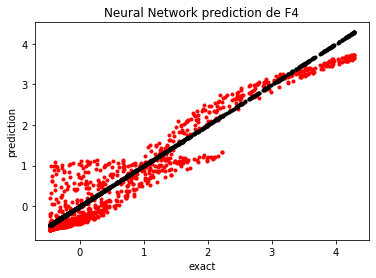

In [54]:
visualize1(model2,data_test_features,data_test_labels)
visualize2(model2,data_test_features,data_test_labels)
visualize3(model2,data_test_features,data_test_labels)
visualize4(model2,data_test_features,data_test_labels)

# load the models and visualise the results

In [ ]:
Model_1=tf.keras.models.load_model("Advection_2D-structure-1.h5")

# Visualisation de la Loss-fonction

In [36]:
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/fit

#Si cela ne marche pas pour vous, faites d'abord
%tensorboard dev upload --logdir \'logs'
### Dans Anaconda Prompt
### cd C:\Users\jonat\Git\PE-001\Private\Jupyter_notebook\Pull corr\Diffusion1D
### tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 3056), started 0:05:03 ago. (Use '!kill 3056' to kill it.)

Launching TensorBoard...

ValueError: No closing quotation